In [0]:
import nltk.data
import pandas as pd
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv( "/content/drive/My Drive/CSE 6240 Project Materials/Data/Avondale_Restaurant_Review.csv", delimiter=",", engine='python')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def clean_review(review, remove_stopwords = False):
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    cleaned_review = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        cleaned_review = [w for w in cleaned_review if not w in stops]   
    

    #####################
    
    return cleaned_review

In [0]:
def review_to_sentences( review: str, tokenizer: nltk.tokenize.punkt.PunktSentenceTokenizer ):
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    review_sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            review_sentences.append(clean_review(raw_sentence))    
    
    return review_sentences

In [0]:
sentences = []
for review in train["text"]:
    sentences += review_to_sentences(review, tokenizer)

In [0]:
from gensim.models import FastText

def generate_z(sentences):
    model = FastText(sentences, size=100, window=5, min_count=5, workers=4,sg=1)
    word_list = list(model.wv.vocab)
    z=np.array([model[word] for word in word_list])  

    return model, z, word_list

In [0]:
model, z, word_list = generate_z(sentences)

In [0]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

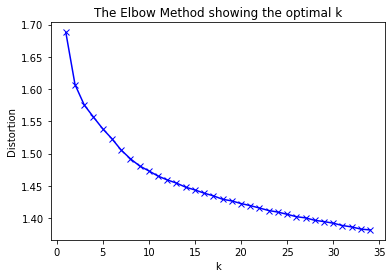

In [10]:
distortions = []
K = range(1,35)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(z)
    kmeanModel.fit(z)
    distortions.append(sum(np.min(cdist(z, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / z.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [0]:
def fit_kmeans(z,word_list_z,num_clusters = 10):
    """ Fit kmeans on the embedding representations and return a mapping of word to cluster indices. Please use the default values for
        the rest of the kmeans parameters.

        Arg: z: word embeddings (ndarray)
              word_list_z: List of tokens in the model (List) 
              num_clusters: Number of clusters (int)
        Returns:
            pre_trained_word2vec_model: word2vec model trained on the tokenized sentences.
            z2: word embeddings (ndarray)
            word_centroid_map_z: A mapping of word to cluster index it belongs to. (Dict)      

    """
    idx = KMeans(n_clusters = num_clusters).fit_predict(z)
    word_centroid_map_z = dict(zip(word_list_z, idx))
    ######################

    return word_centroid_map_z

In [0]:
word_centroid_map = fit_kmeans(z, word_list, 10)

In [13]:
def print_clusters(word_centroid_map, model_name):
    """ Print max(20, cluster_size) words for each of the clusters.

        Args: word_centroid_map_z: A mapping of word to cluster index it belongs to. (Dict)  
              model_name: Model Name (str)


    """
    print("The clusters for {0} are....".format(model_name))
    clust=[]
    for i in range(10):
      clust.append([])
    for key, value in word_centroid_map.items():
      clust[value].append(key)
    
    for i in range(10):
      chr=[]
      for j in range(20):
        try:
          chr.append(clust[i][j])
        except IndexError:
          break
      print('cluster', i+1, ':', chr)

    
    ######################
print_clusters(word_centroid_map, "fastText")

The clusters for fastText are....
cluster 1 : ['let', 'us', 'business', 'me', 'wrong', 'server', 'she', 'former', 'waitress', 'understand', 'how', 'shift', 'kept', 'her', 'ten', 'order', 'correctly', 'keep', 'work', 'heard']
cluster 2 : ['in', 'the', 'trust', 'you', 'wont', 'to', 'i', 'christina', 'and', 'as', 'a', 'can', 'get', 'but', 'even', 'with', 'of', 'that', 'any', 'up']
cluster 3 : ['stars', 'was', 'fantastic', 'overwhelming', 'attentive', 'very', 'friendly', 'always', 'cool', 'food', 'itself', 'pretty', 'good', 'overall', 'is', 'service', 'great', 'super', 'nice', 'priced']
cluster 4 : ['coming', 'ordering', 'disgusting', 'paying', 'returning', 'preparing', 'moving', 'checking', 'poisoning', 'having', 'dancing', 'getting', 'parking', 'finding', 'showing', 'driving', 'leaving', 'making', 'beginning', 'telling']
cluster 5 : ['best', 'chinese', 'highly', 'recommended', 'support', 'this', 'west', 'valley', 'place', 'love', 'location', 'recommend', 'definitely', 'vietnamese', 'area

In [0]:
def create_bag_of_centroids(review, word_centroid_map, num_clusters = 10):
 
    count=np.zeros(num_clusters)
    for token in review:
      try:
        count[word_centroid_map[token]]+=1
      except KeyError:
        continue

    return count

In [0]:
X=[]
num_reviews = train["text"].size
for i in range(num_reviews):
    cr=clean_review(train["text"][i], remove_stopwords = True)
    X.append(create_bag_of_centroids(cr, word_centroid_map, 10))
X=np.array(X)
y = train['stars'].as_matrix()

In [0]:
def split(X, label):
    x_train, x_test, y_train, y_test = train_test_split(X, label, test_size = 0.2, random_state=0)
    return x_train, x_test, y_train, y_test

In [0]:
from warnings import filterwarnings
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import random as rd
filterwarnings('ignore')
import time

def calculateF1(X, y, k = 5):
    rd.seed(0) #Setting a common seed
    start=time.time()
    c_list=[10**i for i in np.random.uniform(-4, 4, 30)]
    f1_list=[]
    kf = KFold(n_splits=k)
    print('itr# Time')
    i=0
    for c in c_list:
        f1score=0.0
        i+=1
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf = LinearSVC(C=c)
            clf = clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            f1score+=f1_score(y_test, y_pred_test, average='weighted')/float(k)
        f1_list.append(f1score)
        if i%5==0:
            print(i, time.time()-start)        
        
    return c_list, f1_list

In [0]:
def findBestC(X, y, k = 5):
    c_list, f1_list = calculateF1(X, y, k)
    f1max = max(f1_list)
    c_best = c_list[f1_list.index(f1max)]
    improvement = f1max - min(f1_list)
    return c_best,improvement

In [0]:
def findImprovement(X,train_sentiment,test_size = 0.2, random_state = 0):
    X_train, X_test, y_train, y_test = train_test_split(X, train_sentiment, test_size=test_size, random_state=random_state)
    c_best, improvement = findBestC(X_train, y_train)
    clf = LinearSVC(C=c_best)
    clf = clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    f1_s = f1_score(y_test, y_pred_test, average='weighted')   

    return c_best,improvement,f1_s

In [20]:
x_train, x_test, y_train, y_test = split(X, y)

c_best,improvement,f1_s = findImprovement(x_train, y_train)
print('best c:', c_best, '; improvement:', improvement, '; test f1_score:', f1_s)

itr# Time
5 48.925292015075684
10 107.07696080207825
15 165.32303404808044
20 204.19981789588928
25 259.10456705093384
30 315.4011607170105
best c: 3.272811047821699 ; improvement: 0.1440995942391406 ; test f1_score: 0.3495222205784044


In [21]:
clf = LinearSVC(C=c_best)
clf = clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)
f1 = f1_score(y_test, y_test_pred, average='weighted') 
print(f1)

0.3879248713634787


In [22]:
y_train_1=y_train[:]
y_train_1[y_train_1<5] = 0
y_train_1[y_train_1==5] = 1
c_best_1,improvement,f1_s = findImprovement(x_train, y_train_1)
print('best c:', c_best_1, '; improvement:', improvement, '; test f1_score:', f1_s)

itr# Time
5 10.341962337493896
10 22.818309783935547
15 35.38808846473694
20 46.58182168006897
25 56.69366502761841
30 69.15168285369873
best c: 0.00019418996808345465 ; improvement: 0.21353466858421755 ; test f1_score: 0.6798978522859024


In [23]:
y_test_1=y_test[:]
y_test_1[y_test_1<5] = 0
y_test_1[y_test_1==5] = 1
clf = LinearSVC(C=c_best_1)
clf = clf.fit(x_train, y_train_1)
y_test_pred = clf.predict(x_test)
f1 = f1_score(y_test_1, y_test_pred, average='weighted') 
print(f1)

0.6666610652741971
